<a href="https://colab.research.google.com/github/jose-cano/Deep-Learning/blob/main/Fast_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai duckduckgo_search

In [2]:
import shutil
import os
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastcore.all import *
from time import sleep
import warnings
warnings.filterwarnings("ignore")

# Build your own Classifier!

In this notebook, we'll build an image classifier using fastai. Fastai is a deep learning library built on top of PyTorch that provides additional tools to quickly build state-of-the-art models for common deep learning domains.

We'll build a model that can classify images into categories.

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of these primates.
2. Fine-tune a pretrained neural network to recognise these two groups
3. Try running this model on a picture of a primate and see if it works.

In [3]:
# Choose categories you want to distinguish
category_1 = "dog"
category_2 = "cat"

# Choose range of conditions to help generalize
condition_1 = "playing"
condition_2 = "running"
condition_3 = "jumping"  # <-- Used for testing on an unseen image

In [4]:
def delete_folder(folder_path):
    # Verify if the folder exists
    if os.path.exists(folder_path):
        # Delete the folder and its contents recursively
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents have been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# folder_path = '/content/categories'
# delete_folder(folder_path)

# 1. Downloading images

In [5]:
def search_images(term, max_images=120):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'dog photos'


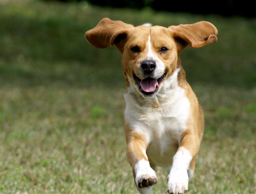

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
# If you get a JSON error, just try running it again (it may take a couple of tries).

urls = search_images(category_1 + ' photos', max_images=1)
dest = category_1 + '.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'cat photos'


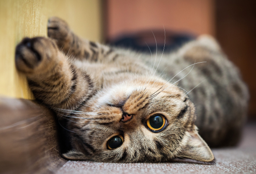

In [7]:
urls = search_images(category_2 + ' photos', max_images=1)
dest = category_2 + '.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

If images seem reasonable, continue. If not, refine search.

In [8]:
searches = category_1, category_2,
path = Path('categories')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} {condition_1} photo'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} {condition_2} photo'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'dog playing photo'
Searching for 'dog running photo'
Searching for 'cat photo'
Searching for 'cat playing photo'
Searching for 'cat running photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

14

# View sample of images that will be used to train model

Next, we'll use another building block from the fastai library, the DataBlock class, which we can use to represent our training data, the labels, data splitting criteria, and any data transformations.

blocks=(ImageBlock, CategoryBlock) is used to specify what kind of data is in the DataBlock. We have images, and categories - hence a tuple of ImageBlock and CategoryBlock classes.

get_items takes the function get_image_files as its parameter. get_image_files is used to find the paths of our input images.

splitter=RandomSplitter(valid_pct=0.2, seed=42) specifies that we want to randomly split our input data into training and validation sets, using 20% data for validation.

get_y=parent_label specifies that the labels for an image file is its parent (the directory that the file belongs to).

item_tfms=[Resize(192, method='squish')] specifies the transformation performed on each file. Here we are resizing each image to 192x192 pixels by squishing it. Another option could be to crop the image.

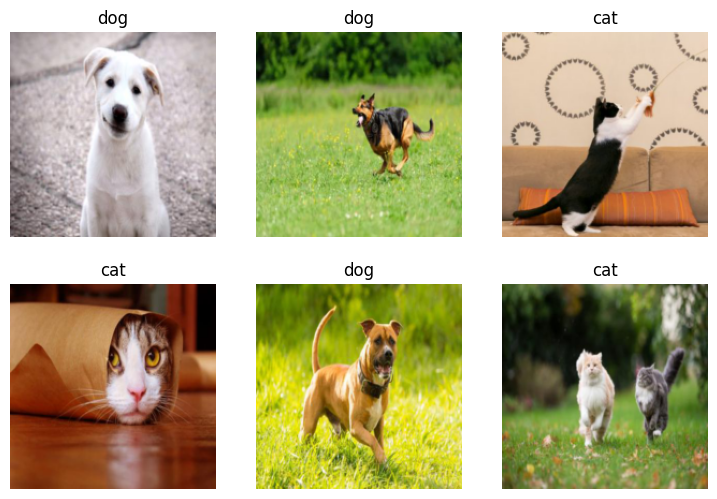

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU. (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

# 2. Train Model

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.677415,0.109361,0.019417,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.242369,0.122283,0.029126,00:02
1,0.161406,0.171486,0.038835,00:03
2,0.127191,0.200189,0.048544,00:03
3,0.090233,0.224978,0.048544,00:02


# Step 3: Use our model

Let's see what our model thinks about an unseen example!

Searching for 'dog jumping'


Predicted label: dog.
Probability: 0.9055


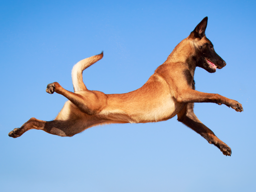

In [12]:
download_url(search_images(f"{category_1} {condition_3}", max_images=1)[0], f"{category_1}_{condition_3}.jpg", show_progress=False)
pred_label,idx,probs = learn.predict(PILImage.create(f"{category_1}_{condition_3}.jpg"))
print(f"Predicted label: {pred_label}.")
print(f"Probability: {probs[idx.item()]:.4f}")
Image.open(f"{category_1}_{condition_3}.jpg").to_thumb(256,256)

Searching for 'cat jumping'


Predicted label: cat.
Probability: 0.9999


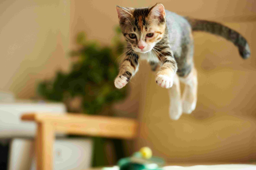

In [13]:
download_url(search_images(f"{category_2} {condition_3}", max_images=1)[0], f"{category_2}_{condition_3}.jpg", show_progress=False)
pred_label,idx,probs = learn.predict(PILImage.create(f"{category_2}_{condition_3}.jpg"))
print(f"Predicted label: {pred_label}.")
print(f"Probability: {probs[idx.item()]:.4f}")
Image.open(f"{category_2}_{condition_3}.jpg").to_thumb(256,256)

In [14]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

By looking at the confusion matrix below, we can assess performance for each category.

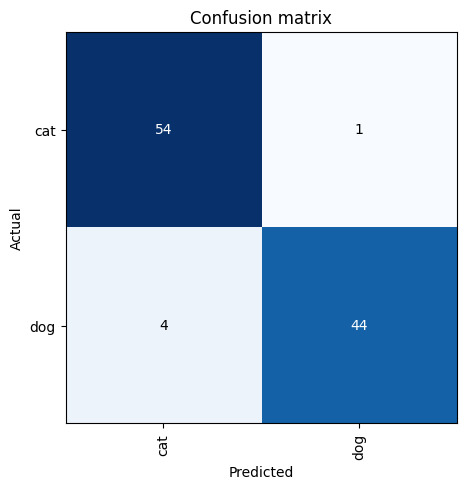

In [15]:
learning_interpreter.plot_confusion_matrix()

Show predictions with highest loss.

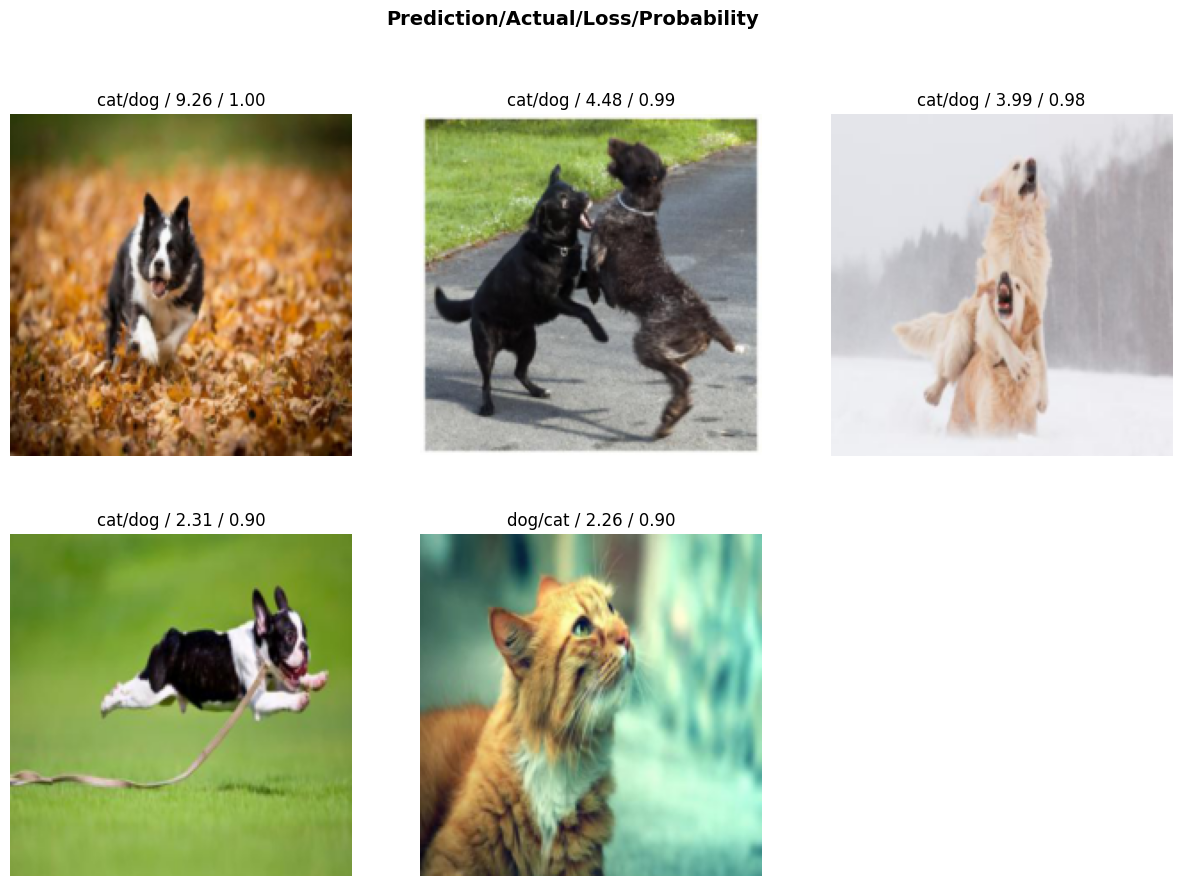

In [16]:
learning_interpreter.plot_top_losses(5, figsize=(15,10))